In [113]:
import pandas as pd
import numpy as np
import pyarrow as pa # чтобы поработать c parquet
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier # попробуем
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

import joblib

from catboost import CatBoostClassifier, Pool # основа

import optuna

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)

##### 1. Читаем датасет

In [2]:
df = pd.read_parquet('../data/dataset.parquet')

##### 2. Смотрим инфо

In [3]:
all_info = pd.DataFrame({
        'Type': df.dtypes,
        'N-unique': df.nunique(),
        'Count': df.count(),
        'Missing': df.isna().sum(),
        'Min': df.select_dtypes('number').min(),            # объектовые колонки не будут обработаны
        'Mean': df.select_dtypes('number').mean(),          # объектовые колонки не будут обработаны
        'Median': df.select_dtypes('number').median(),      # объектовые колонки не будут обработаны
        'Max': df.select_dtypes('number').max(),            # объектовые колонки не будут обработаны
        'Mode': df.mode().loc[0, :]                      
    })\
    .sort_values(by='Type', ascending=False)

In [4]:
all_info

,Type,N-unique,Count,Missing,Min,Mean,Median,Max,Mode
wallet_address,object,74476,442961,0,NaN,NaN,NaN,NaN,0x586e32930ac05127de429bd566eaa2758fcbd9bc
avg_gas_paid_per_tx_eth,float64,441983,442961,0,0.000000e+00,1.568482e-02,1.069098e-02,2.586824e+00,0.0
market_ppo,float64,1375,442961,0,-2.924873e+01,2.020113e+00,1.652219e+00,2.843522e+01,-2.471236
outgoing_tx_avg_eth,float64,433221,442961,0,0.000000e+00,3.189191e+01,1.531728e+00,3.021110e+04,0.0
min_eth_ever,float64,91366,442961,0,0.000000e+00,5.232591e+01,4.806800e-02,5.281967e+05,0.0
max_risk_factor,float64,85362,442961,0,0.000000e+00,1.047412e+04,7.521871e-01,4.461020e+08,0.0
max_eth_ever,float64,99017,442961,0,0.000000e+00,3.293453e+03,5.684796e+01,6.994468e+05,0.0
market_rocr,float64,1375,442961,0,4.541864e-01,1.038512e+00,1.023303e+00,1.768294e+00,0.889739
market_rocp,float64,1375,442961,0,-5.458136e-01,3.851181e-02,2.330308e-02,7.682938e-01,-0.110261
market_plus_dm,float64,1375,442961,0,5.413265e+00,1.062136e+03,3.332466e+02,8.072960e+05,112.544637


In [5]:
# У нас один объектовый признак с большим колическством уникальных значений, смело его дропаем
df = df.drop(columns=['wallet_address'])

In [6]:
all_info

,Type,N-unique,Count,Missing,Min,Mean,Median,Max,Mode
wallet_address,object,74476,442961,0,NaN,NaN,NaN,NaN,0x586e32930ac05127de429bd566eaa2758fcbd9bc
avg_gas_paid_per_tx_eth,float64,441983,442961,0,0.000000e+00,1.568482e-02,1.069098e-02,2.586824e+00,0.0
market_ppo,float64,1375,442961,0,-2.924873e+01,2.020113e+00,1.652219e+00,2.843522e+01,-2.471236
outgoing_tx_avg_eth,float64,433221,442961,0,0.000000e+00,3.189191e+01,1.531728e+00,3.021110e+04,0.0
min_eth_ever,float64,91366,442961,0,0.000000e+00,5.232591e+01,4.806800e-02,5.281967e+05,0.0
max_risk_factor,float64,85362,442961,0,0.000000e+00,1.047412e+04,7.521871e-01,4.461020e+08,0.0
max_eth_ever,float64,99017,442961,0,0.000000e+00,3.293453e+03,5.684796e+01,6.994468e+05,0.0
market_rocr,float64,1375,442961,0,4.541864e-01,1.038512e+00,1.023303e+00,1.768294e+00,0.889739
market_rocp,float64,1375,442961,0,-5.458136e-01,3.851181e-02,2.330308e-02,7.682938e-01,-0.110261
market_plus_dm,float64,1375,442961,0,5.413265e+00,1.062136e+03,3.332466e+02,8.072960e+05,112.544637


In [7]:
pd.reset_option('display.max_rows')

1. Датасет явно связан с Итериумом (криптовалюта). У нас датасет с операциями кошельков.
2. Пропусков нет
3. Все признаки числовые (`float/int`)
4. Очень много выбросов, причем видно что много перекосов.
5. В некоторых столбцах есть цирфа 999999999 - как будто бы искусственное образование
6. Таргет имеет 2 уникальных значения. Следовательно бинрная классификация.
7. Датасет можно поделить на несколько частей:
    - Данные о кошельке.
    - Операции с кошельком.
    - Временные данные (кагда кошелек создан и т.д.).
    - Биржевые метрики.
    - Состояние счетов (кошельков) с точки зрения рисков.

8. **Из всего вышесказанного делаем вывод, что таргет это некий класс который показывает рискованную/не рискованную операцию (заблокировать/ликвидировать)**
9. Так как мы имеем дела чисто с финансовыми данными, будем отталкиваться от корреляции по **Спирмену** (она лучше отрабатывает на выбросах, чем **Пирсон**).


In [8]:
#проверим таргет
df['target'].value_counts()

target
0    276761
1    166200
Name: count, dtype: int64

*На лицо небольшая расбалансировка, что подтверждает наша гипотезу о рискованности операции.*

#### 3. Проверим пренадлежность таргета 1 к риску (или отсутсвие риска). Возьмем моду по признаку risk_factor.

In [9]:
# Если баланс меняется в пользу единиц, значит 1 - это рискованная операция, и наоборот
df[df['risk_factor'] > 0.1].value_counts('target'), df[df['risk_factor'] > 0.7].value_counts('target')

# при увеличении риск-фактора на 0.6 таргет становится менее сбалансированным в пользу единицы.
# единица - рискованная операция, ноль - не рискованная.

(target
 0    169427
 1    132014
 Name: count, dtype: int64,
 target
 1    83452
 0    16003
 Name: count, dtype: int64)

*При увеличении риск-фактора на 0.6 таргет становится менее сбалансированным в пользу единицы.*\
**Единица - рискованная операция, ноль - не рискованная.**

#### 4. Строим корреляцию по Спирмену. Сортируем по убыванию

In [10]:
target_corr = df.corr(method='spearman')['target'].sort_values(ascending=False, key=lambda x: x.abs())

##### 4.1 Возьмем корреляцию с таргетом и отфильтруем по порогу 0.05

In [11]:
# Возьмем корреляцию с таргетом и отфильтруем по порогу 0.05
for_rfc = target_corr[target_corr.abs() > 0.05][1:].index

In [12]:
for_rfc

Index(['risk_factor_above_threshold_daily_count', 'risk_factor',
       'max_risk_factor', 'avg_risk_factor', 'time_since_last_liquidated',
       'liquidation_count', 'liquidation_amount_sum_eth', 'borrow_count',
       'deposit_count', 'borrow_repay_diff_eth', 'avg_weighted_risk_factor',
       'repay_count', 'borrow_amount_sum_eth', 'total_balance_eth',
       'incoming_tx_count', 'borrow_timestamp', 'borrow_block_number',
       'last_tx_timestamp', 'min_eth_ever', 'outgoing_tx_count',
       'unique_borrow_protocol_count', 'risky_tx_count',
       'repay_amount_sum_eth', 'total_collateral_avg_eth',
       'total_gas_paid_eth', 'withdraw_amount_sum_eth',
       'net_incoming_tx_count', 'total_available_borrows_eth',
       'deposit_amount_sum_eth', 'first_tx_timestamp', 'outgoing_tx_sum_eth',
       'market_max_drawdown_365d'],
      dtype='object')

#### 5. Создаем X и y по корреляции

In [13]:
X, y = df[for_rfc], df['target']

In [14]:
# Посмотрим, что попало в X
X

,risk_factor_above_threshold_daily_count,risk_factor,max_risk_factor,avg_risk_factor,time_since_last_liquidated,liquidation_count,liquidation_amount_sum_eth,borrow_count,deposit_count,borrow_repay_diff_eth,avg_weighted_risk_factor,repay_count,borrow_amount_sum_eth,total_balance_eth,incoming_tx_count,borrow_timestamp,borrow_block_number,last_tx_timestamp,min_eth_ever,outgoing_tx_count,unique_borrow_protocol_count,risky_tx_count,repay_amount_sum_eth,total_collateral_avg_eth,total_gas_paid_eth,withdraw_amount_sum_eth,net_incoming_tx_count,total_available_borrows_eth,deposit_amount_sum_eth,first_tx_timestamp,outgoing_tx_sum_eth,market_max_drawdown_365d
0,0.0,0.000001,0.000000,0.000000,999999999.0,0,0.0,0,6,0.000000e+00,0.000000,0,0.000000e+00,58.317987,199,1.557197e+09,7711117,1.557197e+09,0.060948,438,0,0,0.000000e+00,0.000000,0.397391,0.000000e+00,-239,31.575270,4.441099e+01,1.537224e+09,975.686105,-0.895911
1,0.0,0.004953,0.000001,0.000001,999999999.0,0,0.0,1,6,1.571105e-01,0.000000,0,1.571105e-01,58.317987,200,1.557197e+09,7711123,1.557197e+09,0.060948,439,1,0,0.000000e+00,44.479139,0.399063,0.000000e+00,-239,31.418863,4.441099e+01,1.537224e+09,975.686105,-0.895911
2,0.0,0.017103,0.004953,0.002477,999999999.0,0,0.0,2,6,5.432747e-01,0.000387,0,5.432747e-01,58.317987,201,1.557197e+09,7711126,1.557197e+09,0.060948,440,1,0,0.000000e+00,44.479139,0.400895,0.000000e+00,-239,31.035236,4.441099e+01,1.537224e+09,975.686105,-0.895911
3,0.0,0.000001,0.000000,0.000000,999999999.0,0,0.0,0,1,0.000000e+00,0.000000,0,0.000000e+00,0.000000,8,1.557205e+09,7711672,1.557198e+09,0.000000,56,0,0,0.000000e+00,0.000000,0.604001,0.000000e+00,-48,0.000460,7.723285e-04,1.557191e+09,0.103772,-0.895911
4,0.0,0.000001,0.000000,0.000000,999999999.0,0,0.0,0,1,0.000000e+00,0.000000,0,0.000000e+00,0.000000,2,1.557217e+09,7712572,1.557217e+09,0.000000,3,0,0,0.000000e+00,0.000000,0.003008,0.000000e+00,-1,0.007500,1.000000e-02,1.557217e+09,0.010000,-0.895911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442956,0.0,0.000001,0.000000,0.000000,999999999.0,0,0.0,0,1,0.000000e+00,0.000000,0,0.000000e+00,0.505441,68,1.696106e+09,18250961,1.696106e+09,0.007127,91,0,4,0.000000e+00,0.000000,0.352223,0.000000e+00,-23,1.677000,1.949674e+00,1.677567e+09,29.888093,-0.992921
442957,33.0,0.857434,0.891729,0.492528,999999999.0,0,0.0,22,11,5.542753e+01,24.385046,1,6.471729e+01,10.576349,154,1.696115e+09,18251701,1.695934e+09,9.519583,168,1,13,9.289762e+00,101.084776,1.382943,2.424822e+01,-14,22.179067,1.035289e+02,1.624471e+09,341.903119,-0.992921
442958,0.0,0.043993,0.055888,0.044721,999999999.0,0,0.0,1,1,6.238698e-04,0.000046,0,6.238698e-04,0.000222,163,1.696116e+09,18251742,1.696116e+09,0.000217,310,1,33,0.000000e+00,0.026751,1.218006,0.000000e+00,-147,0.029979,9.726859e-03,1.613776e+09,10.111777,-0.992921
442959,0.0,0.444906,0.498686,0.408839,999999999.0,0,0.0,5,4,2.915162e+01,16.806966,0,2.915162e+01,12.076305,117,1.696117e+09,18251864,1.695933e+09,0.000107,221,1,14,0.000000e+00,110.556455,0.738964,0.000000e+00,-104,81.967428,7.929974e+01,1.671973e+09,602.315807,-0.992921


*Отобралось 32 признака, с ними и будет работать*

#### 6. Делим данные на Train, Valid, Test
- Помним, что у нас небольшой дисбаланс = стратификация!

In [15]:
# 0. Бьем на train-val и test
X_tr_vl, X_test, y_tr_vl, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. Бьем train-va на train и valid
X_train, X_valid, y_train, y_valid = train_test_split(X_tr_vl, y_tr_vl, test_size=0.25, random_state=42, stratify=y_tr_vl)

In [16]:
# сохраним датафреймы
pd.concat([X_train, y_train], axis=1).to_parquet('../data/train.parquet')
pd.concat([X_valid, y_valid], axis=1).to_parquet('../data/valid.parquet')
pd.concat([X_test, y_test], axis=1).to_parquet('../data/test.parquet')

#### 7. Тестируем модель на данных

In [ ]:
# прогоним тестово на RFC
model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42,
)

##### 7.1 Обучим

In [32]:
model.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


##### 7.2 Проверим результат

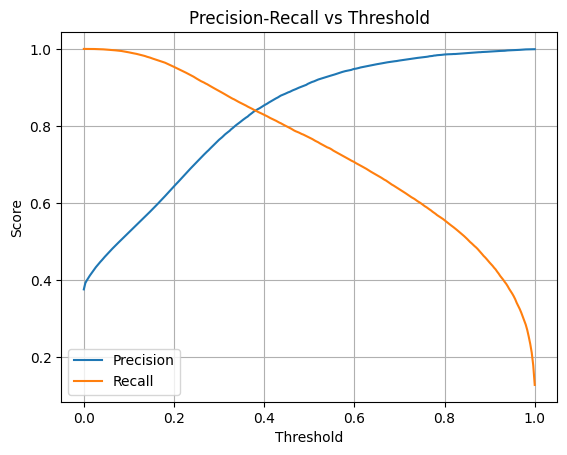

roc_auc:0.9486387847999258
recall: 0.8383574007220217
precision: 0.84182702474096
accuracy_score: 0.8802487809283005
f1_Score: 0.840088630300107
Threshold: 0.38


In [43]:
y_proba = model.predict_proba(X_valid)[:, 1] #берем именно вероятности, так как у нас дисбаланс таргета, а следовательно будет играть трешхолдом по вероятности

precision, recall, thresholds = precision_recall_curve(y_valid, y_proba)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))   # берем трешхолд, который минимизирует разницу между precision и recall
threshold = thresholds[idx]

test_with_trash = np.where(y_proba > threshold, 1, 0)    # берем только те, что выше трешхолда

print(f'roc_auc:{roc_auc_score(y_valid, y_proba)}')
print(f'recall: {recall_score(y_valid, test_with_trash)}')
print(f'precision: {precision_score(y_valid, test_with_trash)}')
print(f'accuracy_score: {accuracy_score(y_valid, test_with_trash)}')
print(f'f1_Score: {f1_score(y_valid, test_with_trash)}')
print(f'Threshold: {threshold}')


*Меня результат уже устраивает, можно сворачиватьс, но идем дальше. Проверим бустинг*

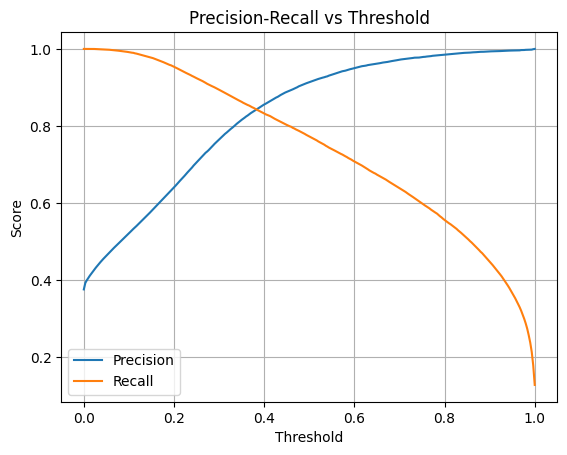

roc_auc:0.9494871733749192
recall: 0.8402827918170879
precision: 0.8454971999394582
accuracy_score: 0.882462497037012
f1_Score: 0.8428819313466617
Threshold: 0.38333333333333336


In [52]:
y_proba = model.predict_proba(X_test)[:, 1] #берем именно вероятности, так как у нас дисбаланс таргета, а следовательно будет играть трешхолдом по вероятности

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))   # берем трешхолд, который минимизирует разницу между precision и recall
threshold = thresholds[idx]

test_with_trash = np.where(y_proba > threshold, 1, 0)    # берем только те, что выше трешхолда

print(f'roc_auc:{roc_auc_score(y_test, y_proba)}')
print(f'recall: {recall_score(y_test, test_with_trash)}')
print(f'precision: {precision_score(y_test, test_with_trash)}')
print(f'accuracy_score: {accuracy_score(y_test, test_with_trash)}')
print(f'f1_Score: {f1_score(y_test, test_with_trash)}')
print(f'Threshold: {threshold}')


##### 7.3  Сохраним метрики и саму модель

In [72]:
metrics_rfc = {
    'roc_auc':0.9494871733749192,
    'recall': 0.8402827918170879,
    'precision': 0.8454971999394582,
    'accuracy_score': 0.882462497037012,
    'f1_Score': 0.8428819313466617,
    'threshold': 0.38333333333333336
}

with open('../models/metrics_rfc.json', 'w') as f:
    json.dump(metrics_rfc, f, indent=4)

In [48]:
joblib.dump(model, "../models/random_forest_model.pkl")

['../models/random_forest_model.pkl']

In [50]:
loaded_model = joblib.load("../models/random_forest_model.pkl")

#### 8. Создаем бустинг. Будем крутить гиперпараметры на optuna

In [ ]:
def objective(trial):
    # Гиперпараметры, которые будем перебирать
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 14),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 16, 128),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        'eval_metric': 'F1',
        'loss_function': trial.suggest_categorical('loss_function', ['Logloss', 'CrossEntropy']),
        'random_seed': 42,
        'task_type': 'GPU',
        'early_stopping_rounds': 50,
        'allow_writing_files': False,
        'verbose': False
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        use_best_model=True
    )

    proba = model.predict_proba(X_valid)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_valid, proba)
    idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))
    treshold = thresholds[idx]
    f1 = f1_score(y_valid, proba > treshold)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

In [ ]:
best_params = study.best_params
best_params

#### 8.1 Обучаем модель на best_param, но:
- возьму поменьше глубину
- увеличу кол-во итераций

In [ ]:
model = CatBoostClassifier(
        iterations=2000,
        eval_metric="F1",
        loss_function="CrossEntropy",
        random_seed=42,
        early_stopping_rounds=80,
        verbose=100,
        allow_writing_files=False,
        task_type="GPU",
        learning_rate=0.112,
        depth=11,
        l2_leaf_reg=1.5256,
        bagging_temperature=0.0001786967138329154,
        border_count=99,
        random_strength=1.11,
    )

model.fit(
    Pool(X_train, y_train),
    eval_set=Pool(X_valid, y_valid),
    use_best_model=True,
)

In [ ]:
y_proba = model.predict_proba(X_valid)[:, 1]  # берем вероятности, так как будет играться трешходом

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_proba)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))
threshold = thresholds[idx]

test_with_trash = np.where(y_proba > threshold, 1, 0)

print(f'roc_auc:{roc_auc_score(y_valid, y_proba)}')
print(f'recall: {recall_score(y_valid, test_with_trash)}')
print(f'precision: {precision_score(y_valid, test_with_trash)}')
print(f'accuracy_score: {accuracy_score(y_valid, test_with_trash)}')
print(f'f1_Score: {f1_score(y_valid, test_with_trash)}')


*Результат не сильно лучше RandomForest, но тоже отличный. p ~ r ~ 0.849 - можно пулять модель в прод*

In [ ]:
confusion_matrix(y_valid, y_proba > threshold)

#### 9. Посмотрим на тест

In [ ]:
y_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.savefig('../plots/precision_recall_test.png')
plt.show()

idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))
threshold = thresholds[idx]

test_with_trash = np.where(y_proba > threshold, 1, 0)

print(f'roc_auc:{roc_auc_score(y_test, y_proba)}')
print(f'recall: {recall_score(y_test, test_with_trash)}')
print(f'precision: {precision_score(y_test, test_with_trash)}')
print(f'accuracy_score: {accuracy_score(y_test, test_with_trash)}')
print(f'f1_Score: {f1_score(y_test, test_with_trash)}')


##### 9.1 Посмотрим на conf_matrix

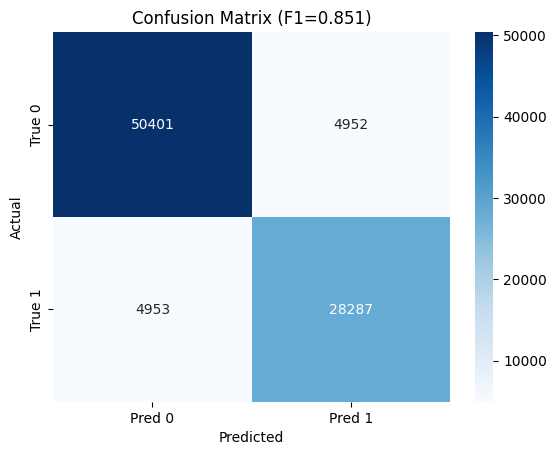

In [ ]:
cm = confusion_matrix(y_test, y_proba > threshold)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (F1={f1_score(y_test, test_with_trash):.3f})')
plt.savefig('../plots/confusion_matrix_cbc.png')
plt.show()

***На тесте результат еще лучше, сохраним метрики***

In [ ]:
metrics = {
    'Roc_auc': roc_auc_score(y_test, y_proba),
    'Recall': recall_score(y_test, test_with_trash),
    'Precision': precision_score(y_test, test_with_trash),
    'Accuracy': accuracy_score(y_test, test_with_trash),
    'F1': f1_score(y_test, test_with_trash),
    'threshold': 0.332875735767647
}

In [ ]:
import json

with open("../models/metrics_catboost.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=4)

#### 10. Построим график ROC AUC

In [ ]:
#roc_auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('../plots/roc_auc_test.png')
plt.show()


#### 11. Сохраним модель

In [ ]:
model.save_model("../models/best_model_catboost.cbm")